# **Campo real**

### **Objetivo:** Graficar el campo real para comprar con inferencias.

**Descripción:** Utilizando el reanálisis de 00Z propuesto, graficarlo.

In [1]:
# Instala librerías necesarias
!pip install basemap
!pip install basemap-data-hires


[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerias necesarias
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from netCDF4 import Dataset
import os

In [3]:
# Define las rutas a los archivos
"""
1: Geopotential: m**2 s**-2 (instant): isobaricInhPa: level 500: fcst time 0 hrs
2: Temperature: K (instant): isobaricInhPa :level 500: fcst time 0 hrs
3: U component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs
4: V component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs

Continua con 06Z, 12Z y 18Z respestando el orden.
"""
ruta_notebook = os.getcwd()
ruta_dir_padre = os.path.dirname(ruta_notebook)
ruta_files = ruta_dir_padre + '/files/'

filename_test = ruta_files + '2018120112.nc'

In [4]:
# Cargar datos desde GRIB
def load_nc_data(filename):
    # Abre el archivo
    ds = Dataset(filename, mode='r')
    #print(ds.variables)
    
    # Selecciona las variables de interés
    alt_geop = ds.variables['z'][:].squeeze()        # Altura del geopotencial [m^2*s^-2]
    u = ds.variables['u'][:].squeeze()               # Componente zonal del viento [m/s]
    v = ds.variables['v'][:].squeeze()               # Componente meridional del viento [m/s]
    temp = ds.variables['t'][:].squeeze()            # Temperatura [K]
    lat = ds.variables['latitude'][:]                # Latitud [º Norte]
    lon = ds.variables['longitude'][:]               # Longitud [º Este]

    # Crear la retícula de puntos equiespaciaods
    lons, lats = np.meshgrid(lon, lat)

    # Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud) - Convertir a Array
    alt_geop = np.array(alt_geop)
    temp = np.array(temp)
    u = np.array(u)
    v = np.array(v)
    lons = np.array(lons)
    lats = np.array(lats)

    return lons, lats, u, v, temp, alt_geop

In [5]:
# Cargar datos de prueba
"""
Dimensiones:

Variables físicas [u, v, temperatura, altura geopotencial]: (4*1, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
*_, u_test, v_test, temp_test, alt_geop_test = load_nc_data(filename_test)

In [6]:
# Dominio de trabajo
lat_N = -20
lat_S = -60
lon_W = -80
lon_E = -50

In [7]:
# Variables de reanálisis ERA-5 0.25°
ds = Dataset(filename_test, mode='r')
lat = ds.variables['latitude'][:]            # Latitud [º Norte]
lon = ds.variables['longitude'][:]           # Longitud [º Este]

# Crear la retícula de puntos equiespaciaods
lons, lats = np.meshgrid(lon, lat)

# Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud)
lons = np.array(lons)
lats = np.array(lats)

In [8]:
# Variable generada
V_test = np.sqrt(np.square(u_test) + np.square(v_test))      # Intensidad del viento [m/s]

In [9]:
# Cambio de unidades variables
V_test = 1.94 * V_test                     # Intensidad del viento [kt]
temp_test = temp_test - 273.15             # Temperatura [ºC]
alt_geop_test = (1/9.8)*alt_geop_test      # Altura Geopotencial [m]

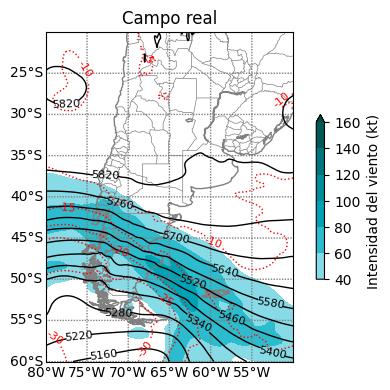

In [11]:
# Crear la figura
plt.figure(figsize=(5, 4))

# Crear el mapa con Basemap
m = Basemap(projection='cyl', resolution='l', llcrnrlat=lat_S, urcrnrlat=lat_N, llcrnrlon=lon_W, urcrnrlon=lon_E)

# Dibujar costas y países
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawparallels(np.arange(-60,-20,5.0),labels=[1,0,0,1], color='gray')
m.drawmeridians(np.arange(-80,-50,5.0),labels=[1,1,0,1], color='gray')

# Graficar la temperatura en isolíneas punteadas cada 5ºC
temp_levels = np.arange(-50, 25, 5)
temp_contours = m.contour(lons, lats, temp_test, levels=temp_levels, linewidths=1, colors='red', linestyles='dotted')
plt.clabel(temp_contours, inline=True, fontsize=8, fmt='%1.0f')

# Graficar la altura geopotencial en línea sólida cada 60 mgp
geopotential_levels = np.arange(5100, 6060, 60)
geopotential_contours = m.contour(lons, lats, alt_geop_test, levels=geopotential_levels, linewidths=1, colors='black')
plt.clabel(geopotential_contours, inline=True, fontsize=8, fmt='%1.0f')

# Definir los niveles de viento en nudos
wind_levels_knots = [40, 60, 80, 100, 120, 140, 160]
# Crear una paleta personalizada de celestes
cmap_celeste = LinearSegmentedColormap.from_list("celestes", ["#b2ebf2", "#00acc1", "#00838f", "#004d40"])
# Graficar la intensidad del viento con contourf para los niveles especificados
wind_contourf = m.contourf(lons, lats, V_test, levels=wind_levels_knots, cmap=cmap_celeste, extend='max')
# Agregar una barra de colores para la intensidad del viento
plt.colorbar(wind_contourf, label='Intensidad del viento (kt)', shrink=0.5)

# Título y visualización
#plt.title("Campos de Temperatura y Alt. Geopotencial (isolineas)\n Intensidad del viento (sombrado) en 500 hPa\n NN - pronóstico a 12 horas, inicializado 20180101 00UTC")
plt.title("Campo real")
plt.tight_layout()
plt.show()